## Setup

In [1]:
!pip3 uninstall tensorflow -yq
!pip3 install tensorflow-gpu>=2.0 gpustat matplotlib -Uq

In [0]:
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools, pickle

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.compat.v2 as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

assert tf.test.is_gpu_available()

In [0]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Image Classification (CIFAR10)

<img src="https://i.imgur.com/E1euTDm.png" width="400px" align="right" style="margin: 0px;padding:1em;">

In this notebook, we will be training a convolutional neural network (CNN) to perform image classification.

The CNN, [first proposed by LeCun et al. in 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) learns to extracts useful features (such as textures, shapes etc.) from images and uses them to perform tasks like image classification. Since then, CNNs like [AlexNet (Krizhevsky et al., 2012)](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) and [ResNet (He et al., 2015)](https://arxiv.org/abs/1512.03385) have achieved breakthroughs in tasks like ImageNet, and saw widespread usage in computer vision.

We will be using the [**CIFAR10 dataset**](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in **10 classes**, with 6000 images per class. It is a commonly used research dataset. There are 50000 training images and 10000 test images. You can see examples of these images on the right side.



In [4]:
!gpustat

c409b6fa3dcc             Sun Dec 29 19:13:43 2019  418.67
[0] Tesla P100-PCIE-16GB | 34'C,   0 % |   265 / 16280 MB |


## Load Dataset

Since CIFAR10 is a widely used research dataset, it is build into `tf.keras.datasets`.

In [0]:
# The data, split between train and test sets

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = np.max(y_train) + 1

# Convert class vectors to one-hot encoded vectors

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

As a best practice, we should normalize the data (scale it from `0~255` to `-1.0~1.0`).

In [0]:
def normalize(ndarray):
    ndarray = ndarray.astype("float32")
    ndarray = (ndarray/127.5) - 1
    return ndarray

x_train = normalize(x_train)
x_test = normalize(x_test)

## Create Model

In [0]:
# model parameters
act = "relu"
pad = "same"
ini = "he_uniform"

model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), kernel_initializer=ini, padding=pad, activation=act, input_shape=x_train.shape[1:]),
    layers.Conv2D(32, (3, 3), kernel_initializer=ini, padding=pad, activation=act),
    layers.Dropout(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), kernel_initializer=ini, padding=pad, activation=act),
    layers.Conv2D(32, (3, 3), kernel_initializer=ini, padding=pad, activation=act),
    layers.Dropout(rate=0.1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(fused=True),
    layers.Flatten(),
    layers.Dense(128, kernel_initializer=ini, activation=act),
    layers.Dropout(rate=0.2),
    layers.Dense(10, kernel_initializer=ini),
    layers.Activation("softmax", dtype=tf.float32)
])

opt = tf.keras.optimizers.Adam(decay=0.001)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["acc"])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0

## Train Model

In [9]:
train_log = model.fit(x_train, y_train,
                      validation_split=0.2,
                      batch_size=128,
                      epochs=30)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 130us/sample - loss: 1.5667 - acc: 0.4443 - val_loss: 1.2964 - val_acc: 0.5344
Epoch 2/30
40000/40000 [==============================] - 3s 73us/sample - loss: 1.1605 - acc: 0.5860 - val_loss: 1.1027 - val_acc: 0.6097
Epoch 3/30
40000/40000 [==============================] - 3s 71us/sample - loss: 0.9712 - acc: 0.6554 - val_loss: 1.0112 - val_acc: 0.6429
Epoch 4/30
40000/40000 [==============================] - 3s 72us/sample - loss: 0.8397 - acc: 0.7049 - val_loss: 0.9659 - val_acc: 0.6625
Epoch 5/30
40000/40000 [==============================] - 3s 71us/sample - loss: 0.7412 - acc: 0.7386 - val_loss: 0.9534 - val_acc: 0.6688
Epoch 6/30
40000/40000 [==============================] - 3s 71us/sample - loss: 0.6675 - acc: 0.7632 - val_loss: 0.8742 - val_acc: 0.6947
Epoch 7/30
40000/40000 [==============================] - 3s 71us/sample - loss: 0.6010 - acc: 0.7853 - val_loss: 0

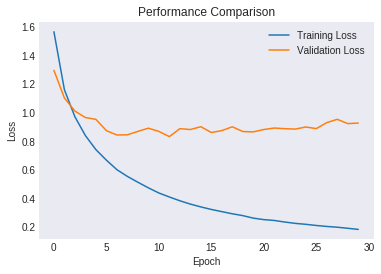

In [10]:
plt.plot(train_log.history["loss"], label="Training Loss")
plt.plot(train_log.history["val_loss"], label="Validation Loss")
plt.title("Performance Comparison")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

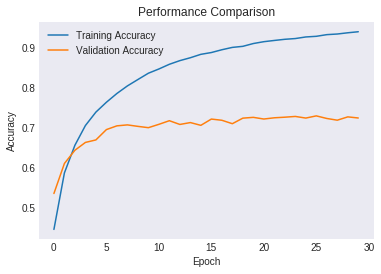

In [11]:
plt.plot(train_log.history["acc"], label="Training Accuracy")
plt.plot(train_log.history["val_acc"], label="Validation Accuracy")
plt.title("Performance Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Evaluate Model

We can evaluate the model using a simple `model.evaluate()`.

In [12]:
score = model.evaluate(x_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

If we want to gain a deeper insight into how well our model is performing, we can use Scikit-Learn's `classification_report`, as well as plot a **confusion matrix**.

* [`classification_report` Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
* [`confusion_report` Document](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [13]:
classes = ["airplane", "automobile", "bird",
           "cat", "deer", "dog", "frog",
           "horse", "ship", "truck"]

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.79      0.74      0.76      1000
  automobile       0.91      0.76      0.83      1000
        bird       0.63      0.65      0.64      1000
         cat       0.51      0.55      0.53      1000
        deer       0.61      0.79      0.69      1000
         dog       0.70      0.58      0.63      1000
        frog       0.77      0.84      0.80      1000
       horse       0.88      0.70      0.78      1000
        ship       0.76      0.87      0.81      1000
       truck       0.84      0.80      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



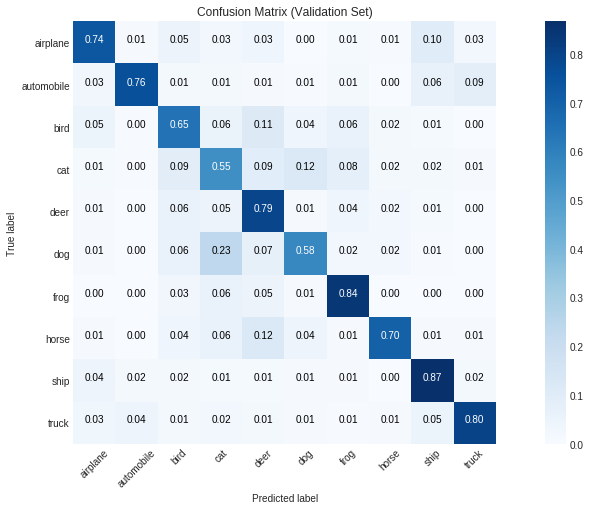

In [14]:
plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

# see the "Setup" section all the way above for
# the code for the `plot_confusion_matrix` function

plot_confusion_matrix(cnf_matrix, labels=classes)